In [44]:
import csv as csv
import pandas as pd
import numpy as np
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

# 读取评论数据集
df = pd.read_csv('20200105-2u.csv')  #训练集
test_df = pd.read_csv('other20200106u.csv') #测试集

col = ['content', 'label']
df = df[col]

cat=[]
for i in range(len(df['label'])):
    if df['label'][i]==1:
        cat.append('阐述')
    if df['label'][i]==2:
        cat.append('推理')
    if df['label'][i]==3:
        cat.append('判断')
    if df['label'][i]==4:
        cat.append('方法')
df['cat']=cat

cat_label_df = df[['cat','label']].drop_duplicates().sort_values('label').reset_index(drop=True)
cat_to_label = dict(cat_label_df.values)
label_to_cat = dict(cat_label_df[['label', 'cat']].values)

d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)

d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,cat,count
0,阐述,1591
1,推理,608
2,方法,447
3,判断,299


In [46]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("stop_words.txt")

In [77]:
# 提取训练集中的文本内容 
train_sentences = df['content']

# 提取测试集中的文本内容 
test_sentences = test_df['content']

#删除除字母,数字，汉字以外的所有符号
train_sentences = train_sentences.apply(remove_punctuation)

#分词，并过滤停用词
train_sentences = train_sentences.map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果
test_sentences = test_sentences.map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果
df['content'] = df['content'].map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果

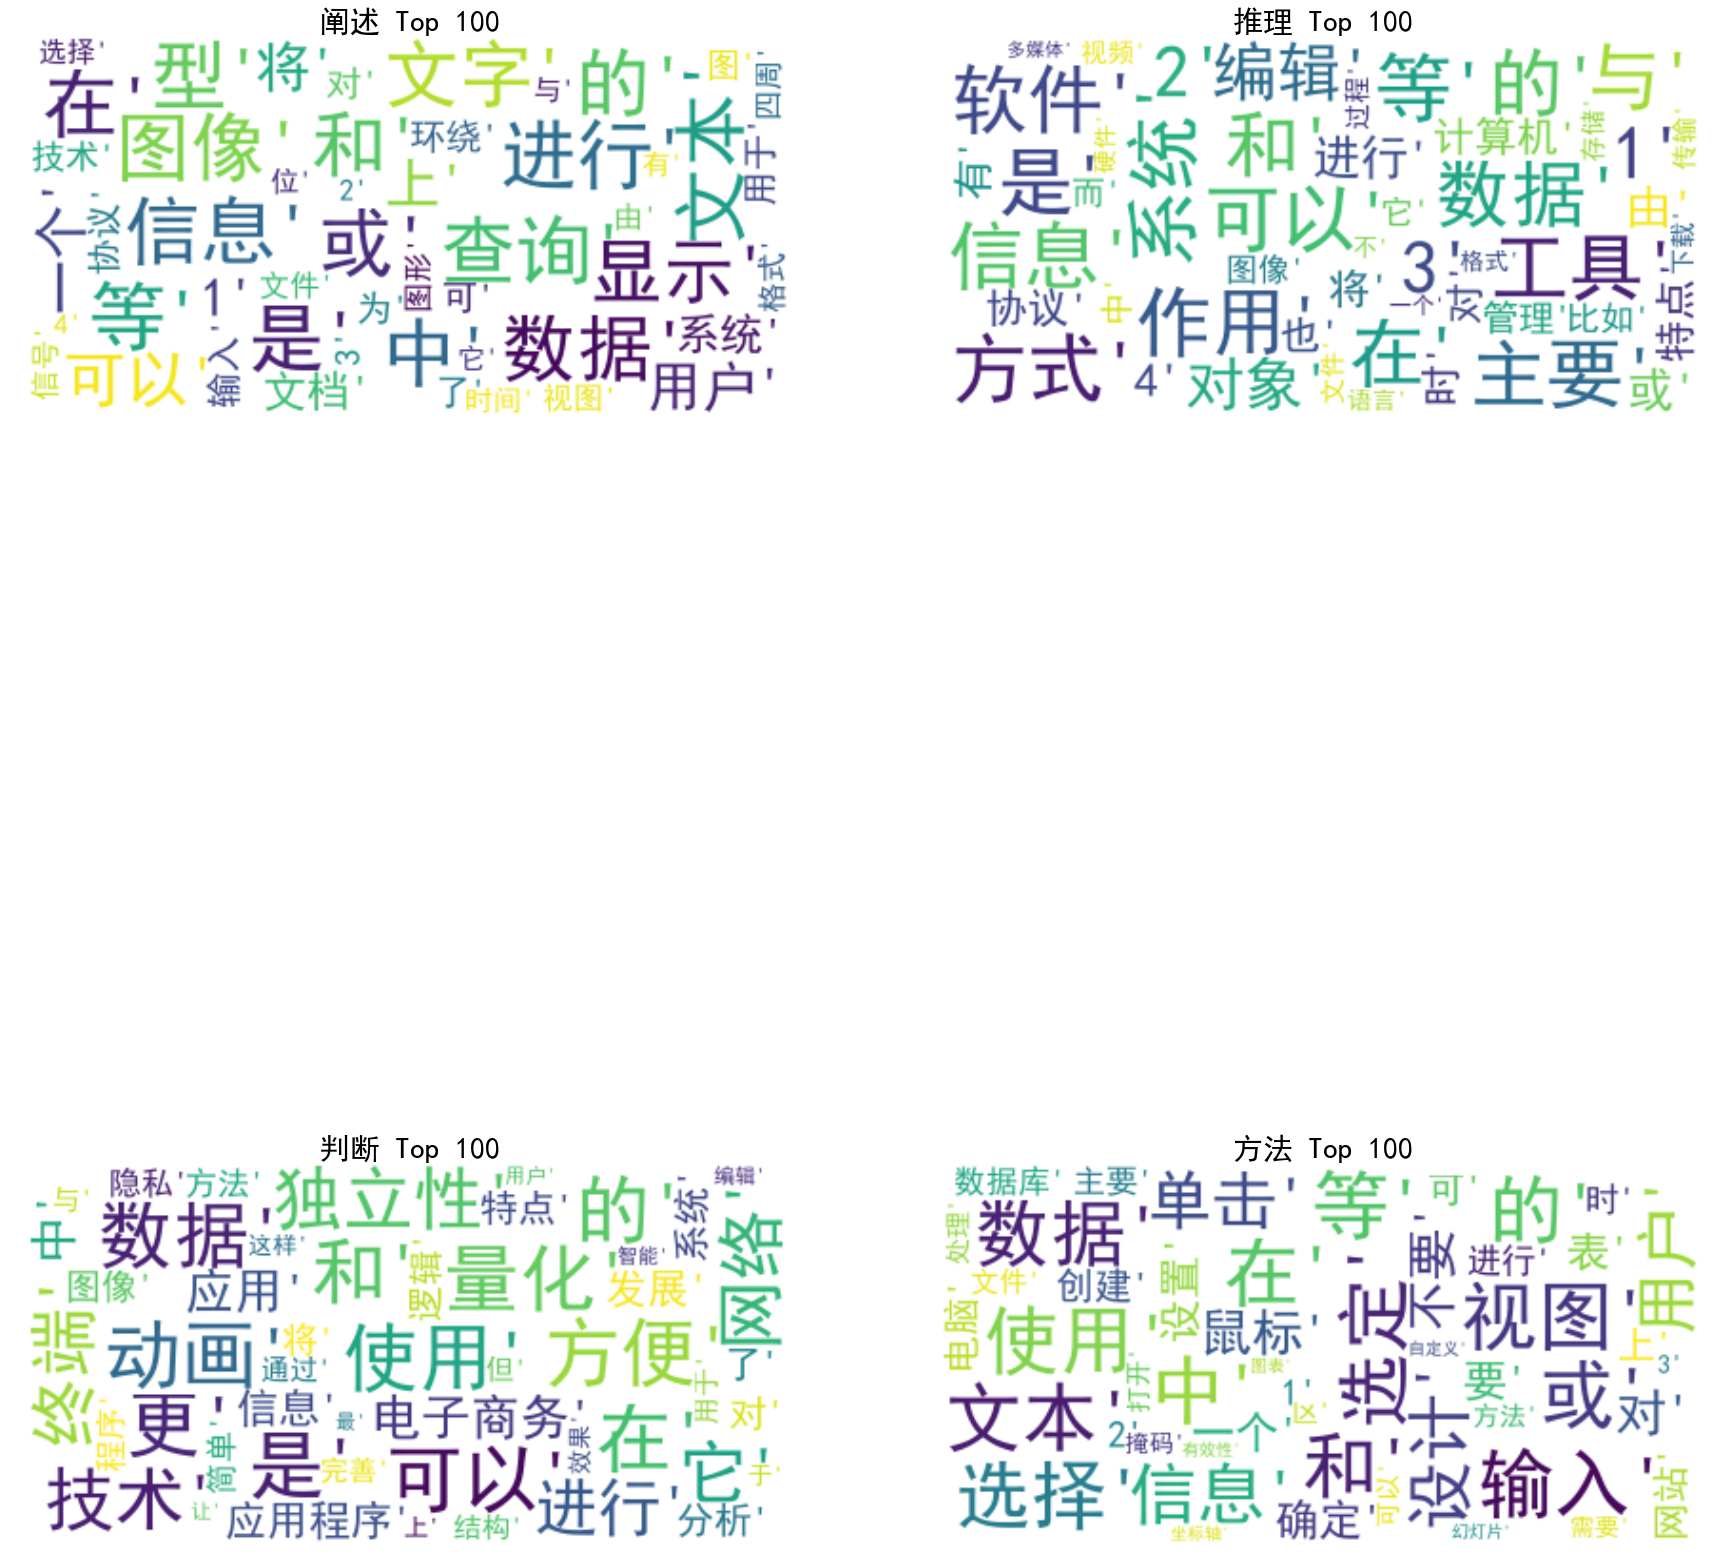

In [78]:
from collections import Counter
from wordcloud import WordCloud
 
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='simhei.ttf',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud
 
cat_desc = dict()
for cat in cat_label_df.cat.values:    
    text = df.loc[df['cat']==cat, 'content']
    text = (' '.join(map(str,text))).split(' ')
    cat_desc[cat]=text
    
fig,axes = plt.subplots(2, 2, figsize=(30, 38))
k=1
for i in range(2):
    for j in range(2):
        cat = label_to_cat[k]
        most100=Counter(cat_desc[cat]).most_common(100)
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(most100), interpolation="bilinear")
        ax.axis('off')
        ax.set_title("{} Top 100".format(cat), fontsize=30)
        k+=1

In [56]:
train_sentences_value=train_sentences.values

In [57]:
#使用imblearn进行随机过采样
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_sentences_value, df.label.values)

In [58]:
re_x=[]
re_y=[]
for x in X_resampled:
    re_x.append(x[0])
for y in y_resampled:
    re_y.append(y)

In [65]:
pd_data = pd.DataFrame(columns=['content','label']) #采样后的训练集df
pd_data['content']=re_x
pd_data['label']=re_y
train_sentences = pd_data['content']
labels = pd_data['label']

In [66]:
# 通过pandas的concat函数将训练集和测试集的文本内容合并到一起
sentences = pd.concat([train_sentences,test_sentences])

# 合并到一起的语料库共有5630行数据
sentences.shape

(9049,)

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
# features = tfidf.fit_transform(df.content)
features = tfidf.fit_transform(sentences)

In [68]:
#查看各个标签的样本量
from collections import Counter
Counter(labels)

Counter({2: 1591, 3: 1591, 4: 1591, 1: 1591})

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_sentences,labels,random_state=0,test_size=0.25, stratify=labels)

X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
 
#训练模型
model = LinearSVC()
# X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.25, stratify=labels)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(y_test)

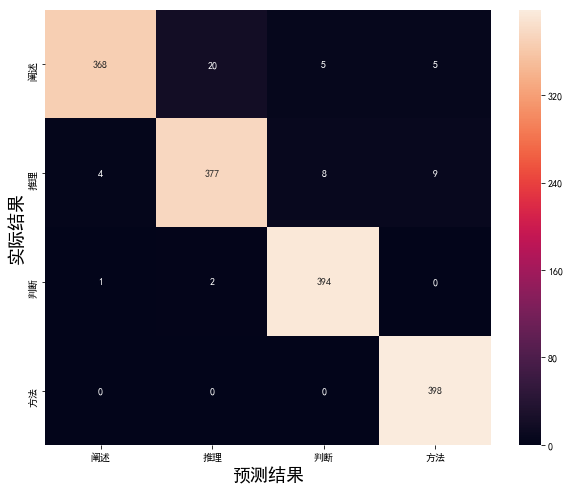

accuracy 0.9660590823381521
              precision    recall  f1-score   support

          阐述       0.99      0.92      0.95       398
          推理       0.94      0.95      0.95       398
          判断       0.97      0.99      0.98       397
          方法       0.97      1.00      0.98       398

    accuracy                           0.97      1591
   macro avg       0.97      0.97      0.97      1591
weighted avg       0.97      0.97      0.97      1591



In [72]:
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_label_df.cat.values, yticklabels=cat_label_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.show()

from sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_label_df['cat'].values))

In [74]:
# 使用TF-IDF对测试集中的文本进行特征工程
test_X = tfidf.transform(test_sentences)
test_y = model.predict(test_X)
# rs=[]
# for predicted in test_y:
#   rs.append(predicted)
# test_df['predict']=rs
# test_df.to_csv('F:\my_csv7.csv', mode='a', header=True)
# print(0)

0


In [81]:
y_score = model.decision_function(X_test)

In [94]:
type(y_test)

pandas.core.series.Series

In [93]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [116]:
y_test=np.array(y_test.tolist())

In [117]:
# 将标签二值化
y_test_bi = label_binarize(y_test, classes=[1,2,3,4])

In [118]:
n_classes=4
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [119]:
# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [120]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

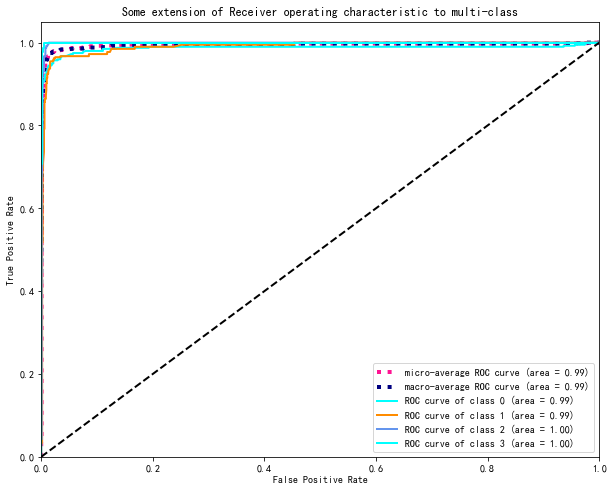

In [121]:
# Plot all ROC curves
lw=2
plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [123]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score)

0.9938611292244687